In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import os

# os.environ["KERAS_BACKEND"] = "tensorflow"

# import tensorflow as tf
# import keras
# from keras import ops
# from keras import layers

from sklearn.svm import OneClassSVM

# Génération Toy Dataset

In [2]:
# idée :
# - génération de bruit ~ Uniform([-1,-1],[1,1]) avec proba p_noise
# - génération de points samplés parmis K gaussiennes avec proba p_gaussiennes

p_noise = 0.10
K = 6  # nombre de Gaussiennes
pi_gaussiennes = [(1-p_noise)/K] * K
N_POINTS = 10000
SIGMA_MAX = 0.25

In [3]:
def create_toy_dataset(n_points=N_POINTS, K=4, p_noise=0.15, pi_gaussiennes=None, sigma_max=None):
    """Create toy dataset of K random 2D gaussians, with noise

    Args:
        n_poins (_type_, optional): total number of points of the dataset. Defaults to N_POINTS.
        K (int, optional): number of gaussians. Defaults to 4.
        p_noise (float, optional): probability of sampling a noise point. Defaults to 0.15.
        p_gaussiennes (_type_, optional): list of probabilities of sampling from each gaussian. sums to 1-p_noise. Defaults to None.
        
    - génération de bruit ~ Uniform([-1,-1],[1,1]) avec proba p_noise
    - génération de points samplés parmis K gaussiennes avec proba p_gaussiennes
    """
    
    if pi_gaussiennes==None:
        pi_gaussiennes = [(1-p_noise)/K] * K
    
    points = np.zeros(shape=(n_points,2))
    labels = np.zeros(shape=(n_points))
    choices = np.arange(K)

    # create Gaussians
    mus = np.random.uniform(low=-1.0, high=1.0, size=(K,2))
    
    if sigma_max==None:
        sigma_max = SIGMA_MAX
    covs = np.zeros(shape=(K,2,2))

    for i in range(K):
        diag = np.array( [ [np.random.uniform(low=0.0, high=sigma_max),0], [0, np.random.uniform(low=0.0, high=sigma_max)] ] )
        theta = np.random.uniform(low=0, high=2*np.pi)
        ortho = np.array( [ [np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        covs[i] = np.matmul( np.transpose(ortho), np.matmul(diag, ortho) )
        
    rng = np.random.default_rng()

    for i in range(n_points):
        p = np.random.uniform()
        if p <= p_noise:
            point = np.random.uniform(low=-1.0-sigma_max*3, high=1+sigma_max*3, size=2)
            label = -1
        else:
            n_gaussienne = np.random.choice(choices)
            label = n_gaussienne
            mu = mus[n_gaussienne]
            sigma = covs[n_gaussienne]
            point = rng.multivariate_normal(mean=mu, cov=sigma)
        points[i] = point
        labels[i] = label
        
    return points, labels, mus, covs, sigma_max

In [4]:
def pdf(mu, cov, x):
    """calcule pdf du point x wrt gaussienne (mu, cov)"""
    determinant = np.linalg.det(cov)
    inverse_sigma = np.linalg.inv(cov)
    D = mu.shape[0]
    pdf = 1/(((2*np.pi)**(D/2))*determinant**(1/2))*np.exp(-1/2*np.matmul((x-mu), np.matmul(inverse_sigma, (x-mu))))
    pdf = pdf.flatten()[0]
    
    return pdf

In [5]:
def display_dataset(points, labels, mus, covs, sigma_max):
    """display dataset"""
    
    fig, ax  = plt.subplots(figsize=(6,6))

    # affiche tous les points
    ax.scatter(points[:,0], points[:,1], c=labels, marker='.', s=2.0, alpha=1.0)
    ax.set_xlim(left=-1.0-sigma_max*5, right=1+sigma_max*5)
    ax.set_ylim(bottom=-1.0-sigma_max*5, top=1+sigma_max*5)
    ax.grid(True)
    
    # affiche les centres des gaussiennes et des contours
    K = mus.shape[0]
    
    for i in range(K):
        # affiche centre
        x_mu = mus[i,0]
        y_mu = mus[i,1]
        ax.scatter(x_mu, y_mu, label=f'Gaussienne {K}', s=100.0, marker='x')
        # calcule contours
        delta = 1.0
        nx = 20
        x = np.linspace( x_mu - delta, x_mu + delta, num=nx)
        # print(x)
        ny = 20
        y = np.linspace( y_mu - delta, y_mu + delta, num=ny)
        # print(y)
        X, Y = np.meshgrid(x, y) # X a shape nx.ny, Y a shape nx.ny
        # print(X)
        # print(Y)
        Z = np.zeros(shape=(ny,nx))
        for j in range(ny):
            for k in range(nx):
                xc = X[j,k]
                yc = Y[j,k]
                point = np.array([xc,yc])
                # print(point)
                Z[j,k] = pdf(mus[i], covs[i], point)
        ax.contour(X,Y,Z)

    return fig, ax

In [6]:
# idée :
# - génération de bruit ~ Uniform([-1,-1],[1,1]) avec proba p_noise
# - génération de points samplés parmis K gaussiennes avec proba p_gaussiennes

p_noise = 0.2
K = 5  # nombre de Gaussiennes
pi_gaussiennes = [(1-p_noise)/K] * K
N_POINTS = 20000
SIGMA_MAX = 0.25

points, labels, mus, covs, sigma_max = create_toy_dataset(n_points=N_POINTS, K=K, p_noise=p_noise, pi_gaussiennes=pi_gaussiennes, sigma_max=SIGMA_MAX)

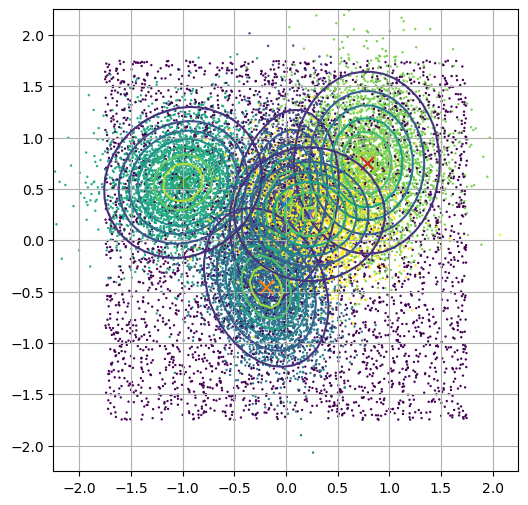

In [7]:
# points, labels, mus, covs, sigma_max = create_toy_dataset(n_points=N_POINTS, K=K, p_noise=p_noise, pi_gaussiennes=pi_gaussiennes)

fig, ax = display_dataset(points, labels, mus, covs, sigma_max)

In [8]:
points.shape

(20000, 2)

### One Class SVM

In [9]:
clf = OneClassSVM(kernel='rbf', gamma='scale').fit(points, verbose=3)

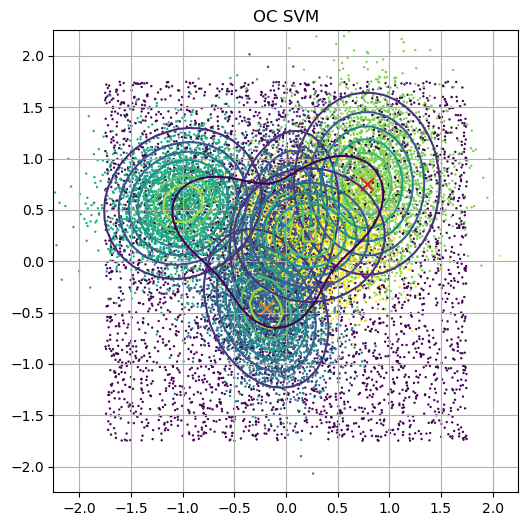

In [10]:
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax = display_dataset(points, labels, mus, covs, sigma_max)

DecisionBoundaryDisplay.from_estimator(
    estimator=clf,
    X=points,
    response_method="decision_function",
    plot_method="contour",
    levels=[0],
    ax=ax
)

ax.set_title('OC SVM')

plt.show()